In [1]:
#%reset
import os
rundir='/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import csv
import rms_plots_v2 as rpl
import matplotlib.pyplot as plt # for basic plotting
import numpy as np
import nc as nc
import glob
import xarray as xr
from scipy import stats
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
plt.style.use('rms_paper')

ystart=1955;ystop=2005;nyear=ystop+1-ystart
years=range(ystart,ystop+1)
print(nyear)

registering cmaps


/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/UTILS/miniconda3/envs/py3a1/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


51


In [2]:
#######################################
### 1.1 READ ERF DATA##################
#######################################
os.chdir(rundir)

###################
### 1.1.1 AR6######
###################

##############declare variables

years=np.arange(1955,2005+1,1);
years2=np.zeros_like(years);nyear=len(years)

erf_ar6={'co2':np.zeros((3,nyear)),
      'ch4':np.zeros((3,nyear)),
      'n2o':np.zeros((3,nyear)),
      'aer':np.zeros((3,nyear)),
      'tot':np.zeros((3,nyear)),
      'o3s':np.zeros((3,nyear)),
      'o3t':np.zeros((3,nyear)),
      'ods':np.zeros((3,nyear)),
      'ghg':np.zeros((3,nyear))}



labels_erf={'co2':'CO$_2$',
        'ch4':'CH$_4$',
        'n2o':'N$_2$O',
        'aer':'AER',
        'tot':'ALL',
        'o3s':'O$_3$,strat',
        'o3t':'O$_3$,trop',
        'ods':'ODS'}
#####################general file (mean)
with open('DATA/IN_ERF_AR6/AR6_ERF_1750-2019.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['co2'][0,i]=float(row[1])
            erf_ar6['ch4'][0,i]=float(row[2])
            erf_ar6['n2o'][0,i]=float(row[3])
            erf_ar6['aer'][0,i]=float(row[15])
            erf_ar6['tot'][0,i]=float(row[19])
            i+=1
        line_count+=1    

    print (titles[1],titles[2],titles[3],titles[15],titles[19])

#####################general file (5%)
with open('DATA/IN_ERF_AR6/AR6_ERF_1750-2019_pc05.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['co2'][1,i]=float(row[1])
            erf_ar6['ch4'][1,i]=float(row[2])
            erf_ar6['n2o'][1,i]=float(row[3])
            erf_ar6['aer'][1,i]=float(row[15])
            erf_ar6['tot'][1,i]=float(row[19])
            i+=1
        line_count+=1    

    print (titles[1],titles[2],titles[3],titles[15],titles[19])
#####################general file (95%)
with open('DATA/IN_ERF_AR6/AR6_ERF_1750-2019_pc95.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['co2'][2,i]=float(row[1])
            erf_ar6['ch4'][2,i]=float(row[2])
            erf_ar6['n2o'][2,i]=float(row[3])
            erf_ar6['aer'][2,i]=float(row[15])
            erf_ar6['tot'][2,i]=float(row[19])
            i+=1
        line_count+=1    

    print (titles[1],titles[2],titles[3],titles[15],titles[19])





co2 ch4 n2o aerosol total
co2 ch4 n2o aerosol total
co2 ch4 n2o aerosol total


In [3]:



#####################o3 file (mean)
with open('DATA/IN_ERF_AR6/o3_erf.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['o3t'][0,i]=float(row[2])
            erf_ar6['o3s'][0,i]=float(row[3])
            i+=1
        line_count+=1    

    print (titles[2],titles[3])

#####################ods (mean)
with open('DATA/IN_ERF_AR6/AR6_ERF_minorGHGs_1750-2019.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['ods'][0,i]=float(row[50])
            i+=1
        line_count+=1    

    print (titles[50])
#####################ODS uncertainty
erf_ar6['ods'][1,:]=erf_ar6['ods'][0,:]*0.81
erf_ar6['ods'][2,:]=erf_ar6['ods'][0,:]*1.19


####################
### 1.1.2 ERF CESM##
####################
nens=10
########## Declare variables
erf={'historical':np.zeros((nens,nyear))*np.nan,
      'fixCO2':np.zeros((nens,nyear))*np.nan,
      'fixODS':np.zeros((nens,nyear))*np.nan}

for i in range(nens): 
    fname='DATA/IN_ERF_CESM/gm_f.e11.B20LE_1955SST_00'+str(i)+'.cam.h0.FLNT_FSNT.1955-2005.nc'
    erf['historical'][i,:]=(nc.getvar(fname,'FSNT')-nc.getvar(fname,'FLNT')).squeeze()
    fname='DATA/IN_ERF_CESM/gm_f.e11.B20LE_1955SST_xOD_00'+str(i)+'.cam.h0.FLNT_FSNT.1955-2005.nc'
    erf['fixODS'][i,:]    =(nc.getvar(fname,'FSNT')-nc.getvar(fname,'FLNT')).squeeze()
    fname='DATA/IN_ERF_CESM/gm_f.e11.B20LE_1955SST_xC2redo_00'+str(i)+'.cam.h0.FLNT_FSNT.1955-2005.nc'
    erf['fixCO2'][i,:]    =(nc.getvar(fname,'FSNT')-nc.getvar(fname,'FLNT')).squeeze()

#######################################
### 1.2 READ GSAT DATA##################
#######################################

########################
### 1.2.1 GSAT CanESM5##
########################
exp_names={'historical':'historical',
           'fixODS':'hist-noCFC',
           'fixCO2':'hist-noCO2'}

gsat={}
files_gsat={};files_asat={}
varnm='TREFHT'
os.chdir(rundir)
for forcing in exp_names.keys():
    #print forcing
    os.chdir('DATA/IN_TAS_CESM/DATA_{}'.format(exp_names[forcing]))
    #make file lists
    files_gsat[forcing]=[]
    for i in range(nens): 
        files_gsat[forcing].extend(glob.glob('*00'+str(i)+'*'+varnm+'*.nc'))
    #declare variables
    gsat[forcing]=np.zeros((nens,nyear))*np.nan
    #read data
    for i,file in enumerate(files_gsat[forcing]):
        gsat[forcing][i,:]=nc.getvar(file,varnm).squeeze()

    os.chdir(rundir)

########################
### 1.2.2 OBSERVATIONS##
########################
tasfile=xr.open_dataset('DATA/DATA_tas_obs_past/SAT_HadCRUT_am_gm_1950_2005.nc')
gsat_obs=tasfile.tas_mean.sel(time=slice('1955-01-01', '2005-12-31')).squeeze()
os.chdir(rundir)


o3_trop o3_strat
ODS_total


In [4]:

#######################################
### 1.4 READ TAO ######################
#######################################

exp_names_toa={'historical':'Full',
                   'fixODS':'xOD',
                   'fixCO2':'xC2'}

toa={}
files_toa={}
files_toa_his1={}
files_toa_his2={}

os.chdir(rundir)
for forcing in exp_names.keys():
    os.chdir('DATA/IN_TOA_COUPLED_CESM/')
    #declare variables
    toa[forcing]=np.zeros((nens,nyear))*np.nan;

    for i in range(nens): 
        if forcing=='historical':
            file1='gm_b.e11.B20LE_Full_'+str(i).zfill(3)+'.cam.h0.FSNT.nc'
            file2='gm_b.e11.B20LE_Full_'+str(i).zfill(3)+'.cam.h0.FLNT.nc'
            print (file1,file2)
            toa[forcing][i,:]=(nc.getvar(file1,'FSNT')-nc.getvar(file2,'FSNT')).squeeze()
        else:   
            file='gm_b.e11.B20LE_'+exp_names_toa[forcing]+'_'+str(i).zfill(3)+'.cam.h0.FLNT_FSNT.1955-2005.nc'
            toa[forcing][i,:]=(nc.getvar(file,'FSNT')-nc.getvar(file,'FLNT')).squeeze()
    os.chdir(rundir)



gm_b.e11.B20LE_Full_000.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_000.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_001.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_001.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_002.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_002.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_003.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_003.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_004.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_004.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_005.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_005.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_006.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_006.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_007.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_007.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_008.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_008.cam.h0.FLNT.nc
gm_b.e11.B20LE_Full_009.cam.h0.FSNT.nc gm_b.e11.B20LE_Full_009.cam.h0.FLNT.nc


In [5]:
#####################################################
##2. Calculations such as  running means
#####################################################
###############runing mean function 
nyear_rm=5
def calc_rm(x):
    x_rm=np.zeros_like(x)*np.nan;dx_rm=np.zeros_like(x)*np.nan
    n=np.shape(x)[0]; nyear=np.shape(x)[1]
    for i in range(n):
        for iyear in range(nyear_rm-1,nyear):
            istart=iyear-nyear_rm+1;istop=iyear+1
            x_rm[i,iyear] =np.mean(x[i,istart:istop]) # running mean, in iyear from iyear-nyear_rm+1 to and including iyear 
            dx_rm[i,iyear]=np.mean(x[i,istart:istop])-np.mean(x[i,0:nyear_rm]) #running mean, relative to first running mean
            #print iyear,istart,istop
    return x_rm,dx_rm

###############
##2.1.1 ERF-AR6##
###############
# remove 1955 values all forcings as for ar6 the erf is given directly and not calculated from difference between all and fixed forcing
erf_ar6_cf1955={}
                
for forcing in (sorted(erf_ar6.keys())):
    erf_ar6_cf1955[forcing]=np.zeros((3,nyear))
    for i in range(3):
        erf_ar6_cf1955[forcing][i,:]=erf_ar6[forcing][i,:]-erf_ar6[forcing][i,0] 

#####################running mean ERF (running mean and running mean compared to first 'nyear_rm' year mean; year corresponds to endyear)
erf_ar6_rm={};derf_ar6_rm={}
for forcing in sorted(erf_ar6.keys()): 
    erf_ar6_rm[forcing],derf_ar6_rm[forcing]=calc_rm(erf_ar6[forcing])

##################
##2.1.2 ERF-CanESM5#
##################

#####################remove 1955 value, but only for historical
erf_historical_cf1955=np.zeros_like(erf['historical'])*np.nan
for i in range(nens):
    erf_historical_cf1955[i,:]=erf['historical'][i,:]-erf['historical'][i,0]

#####################running mean ERF (running mean and running mean compared to first 'nyear_rm' year mean; year corresponds to endyear)
erf_rm={};erf_rm_cf1955={}
for forcing in sorted(erf.keys()): 
    erf_rm[forcing],erf_rm_cf1955[forcing]=calc_rm(erf[forcing])
    
###################
##2.2 GSAT-CESM#
###################

#####################remove 1955 value
gsat_cf1955={}
for forcing in gsat.keys():
    gsat_cf1955[forcing]=np.zeros_like(gsat['historical'])*np.nan
    for i in range(nens):
        gsat_cf1955[forcing][i,:]=gsat[forcing][i,:]-gsat[forcing][i,0]

#####################running mean ERF (running mean and running mean compared to first 'nyearrunning' year mean; year corresponds to endyear)
gsat_rm={};gsat_rm_cf1955={}
for forcing in sorted(gsat.keys()): 
    gsat_rm[forcing],gsat_rm_cf1955[forcing]=calc_rm(gsat[forcing])


###################
##2.4 TOA-CanESM5#####
###################
#####################remove 1955 value
toa_cf1955={}
for forcing in gsat.keys():
    toa_cf1955[forcing]=np.zeros_like(gsat['historical'])*np.nan
    for i in range(nens):
        toa_cf1955[forcing][i,:]=toa[forcing][i,:]-toa[forcing][i,0]


#####################running mean TOA (running mean and running mean compared to first 'nyearrunning' year mean; year corresponds to endyear)
toa_rm={};toa_rm_cf1955={}
for forcing in sorted(toa.keys()): 
    toa_rm[forcing],toa_rm_cf1955[forcing]=calc_rm(toa[forcing])


###################
##2.5 efficacy#####
###################
#GSAT and ERF
gsat_rm_allminforcing={};erf_rm_allminforcing={}

for forcing in ['fixODS','fixCO2']:
    ##gsat
    gsat_rm_allminforcing[forcing]=np.zeros((nens,nyear))
    for i in range(nens):
        gsat_rm_allminforcing[forcing][i,:]=gsat_rm['historical'][i,:]-gsat_rm[forcing][i,:]
    ##erf
    erf_rm_allminforcing[forcing]=np.zeros((nens,nyear))
    for i in range(nens):
        erf_rm_allminforcing[forcing][i,:]=erf_rm['historical'][i,:]-erf_rm[forcing][i,:]

eff_ods_rm=np.zeros((nens,nyear))
eff_aer_rm=np.zeros((nens,nyear))

for i in range(nens):
    eff_ods_rm[i,:]=(gsat_rm_allminforcing['fixODS'][i,:]/gsat_rm_allminforcing['fixCO2'][i,:])/(erf_rm_allminforcing['fixODS'][i,:]/erf_rm_allminforcing['fixCO2'][i,:])  



In [7]:
#####################################################
##3. Calculate ODS and aerosol efficacies
#####################################################
tf = open('DATA/data_GSAT+ASAT+ERF+efficacies_'+str(2005+1-nyear_rm)+'-2005min1955_CESM.txt', "w")

####GSAT [2005+1-nyear_rm]-2005 min 1955 
tf.write('CESM')
tf.write('\n*************GSAT   '+str(2005+1-nyear_rm)+'-2005 minus 1955**********')
dGSAT_all=np.mean(gsat_cf1955['historical'][:,-nyear_rm::])
dGSAT_fods=np.mean(gsat_cf1955['fixODS'][:,-nyear_rm::])
dGSAT_fco2=np.mean(gsat_cf1955['fixCO2'][:,-nyear_rm::])
dGSAT_ods=np.mean(gsat_rm['historical'][:,-1]-gsat_rm['fixODS'][:,-1])
dGSAT_co2=np.mean(gsat_rm['historical'][:,-1]-gsat_rm['fixCO2'][:,-1])

tf.write('\ndGSAT_historical: '+"%5.4f"%(dGSAT_all))
tf.write('\ndGSAT_fixODS: '+"%5.4f"%(dGSAT_fods))
tf.write('\ndGSAT_ods (hist-fix): '+"%5.4f"%(dGSAT_ods))
tf.write('\ndGSAT reduction due to ODS: '+"%5.2f"%(100*(dGSAT_all-dGSAT_fods)/dGSAT_all)+'%')
tf.write('\n')
tf.write('\ndGSAT fixCO2: '+"%5.4f"%(dGSAT_fco2))
tf.write('\ndGSAT CO2 (hist-fix): '+"%5.4f"%(dGSAT_co2))
tf.write('\nT reduction due to CO2: '+"%5.2f"%(100*(dGSAT_all-dGSAT_fco2)/dGSAT_all)+'%')

####GSAT ratios 
tf.write('\n')
tf.write('\n****GSAT ratios') 
tf.write('\ndGSAT_ods/dGSAT_co2: '+ "%6.3f"%(dGSAT_ods/dGSAT_co2))

tf.write('\n\n****ERF and efficacies') 

#ERF
F_ods=np.mean(erf_rm_allminforcing['fixODS'][:,-1])
F_co2=np.mean(erf_rm_allminforcing['fixCO2'][:,-1])

tf.write('\nF_ods:'+ "%6.3f"%(F_ods))
tf.write('\nF_ods CMIP6: '+"%6.3f"%(np.mean(erf_ar6_cf1955['ods'][0,-nyear_rm::]))+'  ('+"%6.3f"%(np.mean(erf_ar6_cf1955['ods'][1,-nyear_rm::])) + '-'+"%6.3f"%(np.mean(erf_ar6_cf1955['ods'][2,-nyear_rm::]))+')')

tf.write('\nF_co2:'+ "%6.3f"%(F_co2))
tf.write('\nF_co2 CMIP6: '+"%6.3f"%(np.mean(erf_ar6_cf1955['co2'][0,-nyear_rm::]))+'  ('+"%6.3f"%(np.mean(erf_ar6_cf1955['co2'][1,-nyear_rm::])) + '-'+"%6.3f"%(np.mean(erf_ar6_cf1955['co2'][2,-nyear_rm::]))+')')


tf.write('\nF_ods/F_co2:'+ "%6.3f"%(F_ods/F_co2))
tf.write('\ndGSAT_co2/F_co2:'+ "%6.3f"%(dGSAT_co2/F_co2))

#efficacy
tf.write('\nmean of ODS efficacies: '+"%6.3f"%(np.mean(eff_ods_rm[:,-1])))

t,p=stats.ttest_1samp(eff_ods_rm[:,-1],1)
tf.write('\np-value that ODS differs from 1 (1-sided)'+"%6.3f"%(p/2)) 
tf.write('\nODS efficacy based on means: ' +"%6.3f"%((dGSAT_ods/dGSAT_co2)/(F_ods/F_co2)))  


#feedbacks
N_co2=np.mean(toa_rm['historical'][:,-1]-toa_rm['fixCO2'][:,-1])
N_ods=np.mean(toa_rm['historical'][:,-1]-toa_rm['fixODS'][:,-1])
tf.write('\n\n Feedbacks')
tf.write('\nN_CO2:'+"%6.3f"%(N_co2))
tf.write('\nN_ods:'+"%6.3f"%(N_ods))

tf.write('\nfeedback_ods:'+"%6.3f"%(dGSAT_ods/(F_ods-N_ods)))
tf.write('\nfeedback_CO2:'+"%6.3f"%(dGSAT_co2/(F_co2-N_co2)))

tf.write('\nfeedback_ods_noN:'+"%6.3f"%(dGSAT_ods/(F_ods)))
tf.write('\nfeedback_CO2_noN:'+"%6.3f"%(dGSAT_co2/(F_co2)))


tf.close()

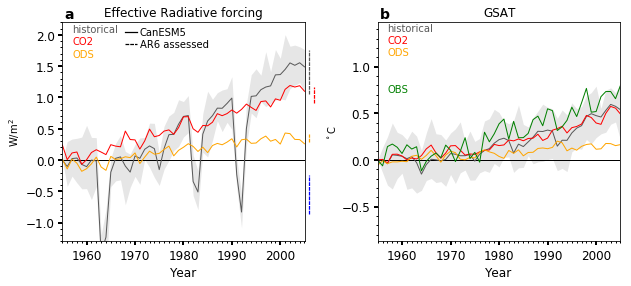

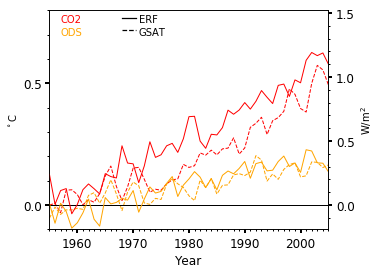

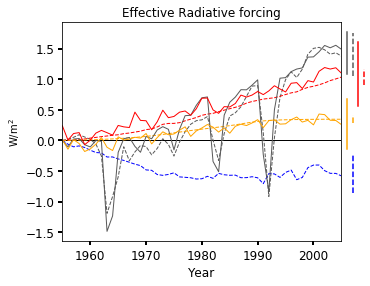

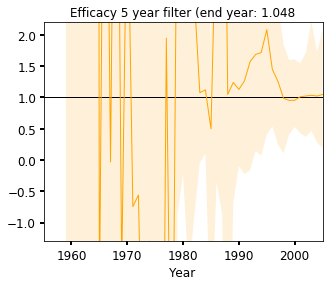

In [8]:
#####################################################
##4. PLOTS
#####################################################
colors={'historical':[0.35,0.35,0.35],
        'fixODS':'orange',
        'fixODSO3':'brown',
        'fixaerosol':'royalblue',
        'fixCO2':'red'        
       } 
colors_ar6_erf={'co2':'red',
        'ch4':'purple',
        'n2o':'cyan',
        'aer':'blue',
        'tot':[0.35,0.35,0.35],
        'o3s':'brown',
        'o3t':'green',
        'ods':'orange'}
labels_dif={'historical':'historical',
        'fixODS':'ODS',
        'fixCO2':'CO2',
        'fixaerosol':'aerosol',
        'fixODSO3':'ODSO$_3$'}

##################################
##4.1a. Timeseries ERF+GSAT#
##################################

fig1, axs = plt.subplots(1,2, figsize=(10,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)

#############ERF
ax=axs[0]
# axes
ax.set_xlim([1955, 2005.1]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-1.3, 2.2]) 
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('W/m$^2$')
# legend
ax.plot([1968,1970.5],[2.05,2.05], color='k',clip_on=False,linestyle='-',linewidth=1.25) 
ax.text(1971,2.0,'CanESM5')
ax.plot([1968,1970.5],[1.85,1.85], color='k',clip_on=False,linestyle=(0,(3,0.8)),linewidth=1.25) #cmip6 uncertainty
ax.text(1971,1.8,'AR6 assessed')


##plot Canesm5
for i,forcing in enumerate (['historical','fixCO2','fixODS']):
    #var
    if forcing=='historical': x=erf_historical_cf1955
    else: x=erf['historical']-erf[forcing]
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries
    if forcing=='historical':
        ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,2.05-i*0.2,labels_dif[forcing],color=colors[forcing]) 
##AR6 range
for i,forcing in enumerate (['tot','ods','co2','aer']):
    if forcing=='co2': offset=1; 
    else: offset=0
    ax.plot([2006+offset,2006+offset],[erf_ar6_cf1955[forcing][1,-1],erf_ar6_cf1955[forcing][2,-1]], color=colors_ar6_erf[forcing],clip_on=False,linestyle=(0,(3,0.8)),linewidth=1.25) #cmip6 uncertainty0
    
rpl.add_title(ax,'Effective Radiative forcing','a')

#############GSAT
ax=axs[1]
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-1.3*0.67, 2.2*0.67])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##Canesm5
for i,forcing in enumerate (['historical','fixCO2','fixODS']):
    #var
    if forcing=='historical': x=gsat_cf1955['historical']
    else: x=gsat['historical']-gsat[forcing]
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) 
    if forcing=='historical':
        ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,1.38-i*0.13,labels_dif[forcing],color=colors[forcing])
#obs
ax.plot(years,gsat_obs[:]-gsat_obs[0],linewidth=1, color='green') 
ax.text(1957,1.38-5*0.13,'OBS',color='green')

rpl.add_title(ax,'GSAT','b')


rpl.mysavefig(fig1,'PLOTS/GSAT+ERF_timeseries_CESM.png')


##################################
##4.1b. Timeseries ERF+GSAT in 1 plot#
##################################

fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)

#############GSAT
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-0.1, 0.8])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##Canesm5
for i,forcing in enumerate (['fixCO2','fixODS']):
    #var
    x=gsat['historical']-gsat[forcing]
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing], linestyle='--') 
    # legend
    ax.text(1957,0.75-i*0.05,labels_dif[forcing],color=colors[forcing])

ax.plot([1968,1970.5],[0.77,0.77], color='k',clip_on=False,linestyle='-',linewidth=1.25) 
ax.text(1971,0.75,'ERF')
ax.plot([1968,1970.5],[0.72,0.72], color='k',clip_on=False,linestyle='--',linewidth=1.25) #cmip6 uncertainty
ax.text(1971,0.7,'GSAT')


#############ERF
ax2 = ax.twinx()
ax2.set_xlim([1955, 2005])

ax2.set_ylim([-0.1*1.9, 0.8*1.9])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.set_xlabel('Year',size='large')
ax2.axhline(y=0,color="black",linewidth=1)
ax2.set_ylabel('W/m$^2$')
ax2.yaxis.set_ticks_position('right')

##plot Canesm5
for i,forcing in enumerate (['fixODS','fixCO2']):
    #var
    x=erf['historical']-erf[forcing]
    # range
    ax2.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries

rpl.mysavefig(fig1,'PLOTS/GSAT+ERF_ODS+CO2_CESM.png')


####################################
##4.1c. ERF: include AR6 timeseries##
####################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('W/m$^2$')
#AR6
for i,forcing in enumerate (['tot','co2','ods','aer']):
    ax.plot(years,erf_ar6_cf1955[forcing][0,:],linewidth=1, color=colors_ar6_erf[forcing],linestyle='--') #cmip6 timeseries
    if forcing=='co2': offset=2; 
    else: offset=0
    ax.plot([2006+offset+1,2006+offset+1],[erf_ar6_cf1955[forcing][1,-1],erf_ar6_cf1955[forcing][2,-1]], color=colors_ar6_erf[forcing],linestyle='--',clip_on=False) #cmip6 uncertainty
#CanESM5
for i,forcing in enumerate (['historical','fixCO2','fixODS']):
    #var
    if forcing=='historical': x=erf_historical_cf1955
    else: x=erf['historical']-erf[forcing]
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries
    #range
    if forcing=='fixCO2': offset=2; 
    else: offset=0
    ax.plot([2006+offset,2006+offset],[np.min(x[:,-1]),np.max(x[:,-1])], color=colors[forcing],clip_on=False) #canesm5range

##title,save
rpl.add_title(ax,'Effective Radiative forcing')
rpl.mysavefig(fig1,'PLOTS/ERF_timeseries_withAR6timeseries_CESM.png')





####################################
##4.1e. efficacy: CanESM5timeseries##
####################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.set_xlabel('Year',size='large')
ax.set_ylim([-1.3, 2.2])
ax.axhline(y=1,color="black",linewidth=1)

ax.plot(years,np.mean(eff_ods_rm,axis=0),linewidth=1, color=colors['fixODS'])
ax.fill_between(years,np.min(eff_ods_rm,axis=0), np.max(eff_ods_rm,axis=0),color=colors['fixODS'], alpha=0.15, linewidth=0)

rpl.add_title(ax,'Efficacy '+str(nyear_rm)+' year filter (end year:'+"%6.3f"%np.mean(eff_ods_rm[:,-1],axis=0))        
rpl.mysavefig(fig1,'PLOTS/ODS_efficacy_runningmean'+str(nyear_rm)+'years_CESM.png')




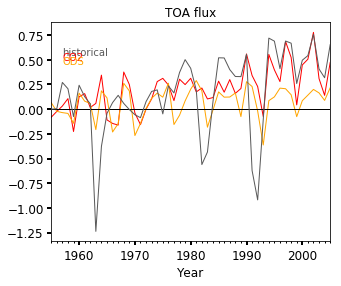

In [9]:

##################################
##4.3. TOA#######################
##################################

fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)


#############GSAT
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.set_ylim([-3, 3])
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
#ax.set_ylabel('10$^6$ km$^2$')

##Canesm5
for i,forcing in enumerate (['historical','fixCO2','fixODS']):
    #var
    if forcing=='historical': x=toa_cf1955['historical'];zorder=15
    else: x=toa['historical']-toa[forcing];zorder=1

    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing],zorder=zorder) 
    #if forcing=='historical':
    #    ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,0.55-i*0.05,labels_dif[forcing],color=colors[forcing])


rpl.add_title(ax,'TOA flux','')    
rpl.mysavefig(fig1,'PLOTS/TOA_timeseries_CESM.png')


tot 1.44479078151 1.15638469123 1.78789780555
ods 0.3461036228 0.280343934468 0.411863311132
co2 0.973703247454 0.857099952203 1.09007839505


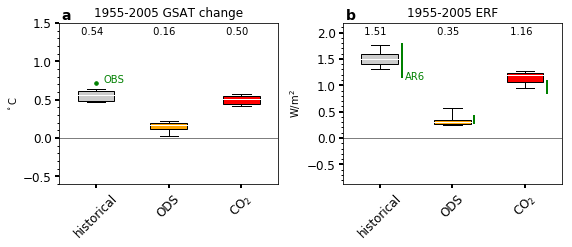

In [10]:
####################################
##4.5. bar plots############
####################################

###################################################
##4.5.1 GSAT+ERF bar plots version 1: (2005-nyear_rm+1)=2005 min 1955#
###################################################

#=set up figure=====================================================

fig1, axs = plt.subplots(1,2, figsize=(9,8)); 
fig1.subplots_adjust(bottom=0.6,hspace=0.5,wspace=0.3)

#gs1 = gridspec.GridSpec(nrows=2, ncols=1, right=0.45,
#                        wspace=0.15,hspace=0.5)

#gs2 = gridspec.GridSpec(nrows=1, ncols=1, left=0.55,right=0.83,
#                        bottom=0.61,wspace=0.15,hspace=0.2)

#gs3 = gridspec.GridSpec(nrows=1, ncols=1, left=0.55,
#                        top=0.475,wspace=0.15,hspace=0.2)


#ax1=plt.subplot(gs1[0])
#ax2=plt.subplot(gs2[0])

ax1=axs[0]
ax2=axs[1]




plot_forcings=['historical','fixODS','fixCO2']
plot_colors=[[0.8,0.8,0.8],colors['fixODS'],colors['fixCO2']]



#=GSAT=====================================================
ax=ax1
rpl.add_title(ax,'1955-2005 GSAT change','a')
#xaxis
ax.set_xlim([0.5, 3.5]);  
ax.set_xticks(np.arange(1,3+1))
#yaxis
ymin=-0.6;ymax=1.5;ylabpos=1.35
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('$^\circ$C')
#plot obs
ax.scatter(1,np.mean(gsat_obs[-nyear_rm::])-gsat_obs[0],50,'green','.',zorder=10)
ax.text(1.1,np.mean(gsat_obs[-nyear_rm::])-gsat_obs[0],'OBS',color='green')
#canesm5 collect data
plot_data=np.zeros((nens,3))*np.nan
for f,forcing in enumerate(plot_forcings):
    if forcing=='historical':
        plot_data[:,f]=np.mean(gsat_cf1955['historical'][:,-nyear_rm::],axis=1)
    else:
        plot_data[:,f]=gsat_rm['historical'][:,-1]-gsat_rm[forcing][:,-1]
#canesm5 raw data
#for f in range(5):
#    ax.scatter(np.ones(nens)*f+1,plot_data[:,f],2,color='k')    
#canesm5 box and whisker plots
bp=ax.boxplot(plot_data,
            whis=(5,95),
            medianprops={"color": "white", "linewidth": 1},
            patch_artist=True, #fill with color
            bootstrap=10000,
            showfliers=False,
            widths=0.5) 
for patch, color in zip(bp['boxes'], plot_colors): patch.set_facecolor(color)
#labels and numbers
for f,forcing in enumerate(plot_forcings):
    ax.text(f+1-0.25,ylabpos,"%5.2f"%(np.mean(plot_data[:,f])))
    #xaxislabel
    ax.set_xticklabels(['historical','ODS','CO$_2$'],rotation=45)

#=ERF=====================================================
ax=ax2
rpl.add_title(ax,'1955-2005 ERF','b')
#xaxis
ax.set_xlim([0.5, 3.5]);  
ax.set_xticks(np.arange(1,3+1))
#yaxis
ax.set_ylim([ymin/0.687, ymax/0.687])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('W/m$^2$')
#plot AR6
for i,forcing in enumerate(['tot','ods','co2']):
    var_min=np.mean(erf_ar6_cf1955[forcing][1,-nyear_rm::])
    var_max=np.mean(erf_ar6_cf1955[forcing][2,-nyear_rm::])
    var_mean=np.mean(erf_ar6_cf1955[forcing][0,-nyear_rm::])
    ax.plot([i+1.3,i+1.3],[var_min,var_max],color='green',linewidth=2,zorder=15)
    #ax.scatter(i+0.7,var_mean,30,'green','.',zorder=15)
    print (forcing,var_mean,var_min,var_max)

#canesm5 collect data
plot_data=np.zeros((nens,3))*np.nan
for f,forcing in enumerate(['historical','fixODS','fixCO2']):
    if forcing=='historical':
        plot_data[:,f]=np.mean(erf_historical_cf1955[:,-nyear_rm::],axis=1)
    else:
        plot_data[:,f]=erf_rm['historical'][:,-1]-erf_rm[forcing][:,-1]
#canesm5 raw data
#for f in range(5):
#    ax.scatter(np.ones(nens)*f+1,plot_data[:,f],2,color='k')    
#canesm5 box and whisker plots
bp=ax.boxplot(plot_data,
            whis=(5,95),
            medianprops={"color": "white", "linewidth": 1},
            patch_artist=True, #fill with color
            bootstrap=10000,
            showfliers=False,
            widths=0.5) 
for patch, color in zip(bp['boxes'], plot_colors): patch.set_facecolor(color)
#labels and numbers
for f,forcing in enumerate(['historical','fixODS','fixCO2']):
    ax.text(f+1-0.25,ylabpos/0.687,"%5.2f"%(np.mean(plot_data[:,f])))
    #xaxislabel
    ax.set_xticklabels(['historical','ODS','CO$_2$'],rotation=45)
#AR6 legend
ax.text(1.35,1.1,'AR6',color='green')



rpl.mysavefig(fig1,'PLOTS/barplot_'+str(2005+1-nyear_rm)+'-2005min1955_CESM.png')





